# 1. Business Understanding

Driven by a desire to deeply understand the US rental market, this data project closely analyzes Zillow's rent data from January 2015 to April 2024. My aim is to provide a clear and detailed analysis of rent changes across all US regions. By studying the Zillow Rent Index (ZRI), which carefully measures rent changes, I plan to predict future rent prices for each state and identify the top 5 cities with the highest and lowest rents. Furthermore, I will present a Rent Price Stability analysis and a Seasonal Rent Price analysis. This information is valuable for everyone interested in US rents. For instance, renters can use the affordability insights and seasonal trends to make informed housing choices. Real estate investors can leverage the high and low rent city identification and stability analysis for strategic investment decisions. Policymakers can utilize the regional trends and understanding of price drivers to inform urban planning and address housing affordability. This detailed look at each region will show important trends and differences, helping with investment decisions, city planning, and where people choose to live. Ultimately, this project seeks to explain what affects rent prices, like population shifts, the economy, and housing availability, to help understand and solve housing affordability issues nationwide.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_plotly
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
import ipywidgets as widgets
from IPython.display import display

In [3]:
df = pd.read_csv('melted_dataframe.csv')

In [4]:
# Display first few rows
df.head()

RegionID  SizeRank       RegionName RegionType StateName        Date  \
0    394913         1     New York, NY        msa        NY  2015-01-31   
1    753899         2  Los Angeles, CA        msa        CA  2015-01-31   
2    394463         3      Chicago, IL        msa        IL  2015-01-31   
3    394514         4       Dallas, TX        msa        TX  2015-01-31   
4    394692         5      Houston, TX        msa        TX  2015-01-31   

         Value  
0  2332.141887  
1  1832.730335  
2  1451.965010  
3  1113.846731  
4  1246.658328

# 2. Data Wrangling

There are 36,293 records and seven variables - two 'int64' variables, 3 'object' variables, 1 'datetime' variable, and 'float64' variable. There are no missing values ore duplicates for any respective feature.

In [5]:
df.isnull().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
Date          0
Value         0
dtype: int64

In [6]:
# Convert date columns to datetime (if applicable)
df['Date'] = pd.to_datetime(df['Date'])  # Replace with actual date column name


In [7]:
# Check for duplicate rows
df = df.drop_duplicates()

In [33]:
print(df.dtypes)
print(df.shape)

RegionID               int64
SizeRank               int64
RegionName            object
RegionType            object
StateName             object
Date          datetime64[ns]
Value                float64
dtype: object
(36293, 7)


# 3. Exploratory Data Analysis

### 3.1 ADF and PACF

ACF: The Autocorrelation Function shows a significant spike at lag 1, and then the autocorrelations gradually tail off, remaining above the significance band for a number of lags. This slow decay suggests that past values have a persistent influence on the current value.

PACF: The Partial Autocorrelation Function shows significant spikes at lags 1 and potentially 2 (though the spike at lag 2 is smaller and closer to the significance band). After these initial spikes, the partial autocorrelations drop off relatively quickly and fall within the insignificant range.

This pattern is indicative of an Autoregressive (AR) model. The significant spikes in the PACF suggest the order of the AR process. Here, the significant spikes at lags 1 and possibly 2 suggest that an AR(1) or AR(2) model might be appropriate.

The p-value (2.35e-20) is WAY smaller than any common significance level (like 0.05 or even 0.01). We reject the null hypothesis. This provides strong statistical evidence that the "Value" column with respect to time is indeed stationary.

ADF Statistic: -11.192113602456287
p-value: 2.354831663775408e-20
Stationary


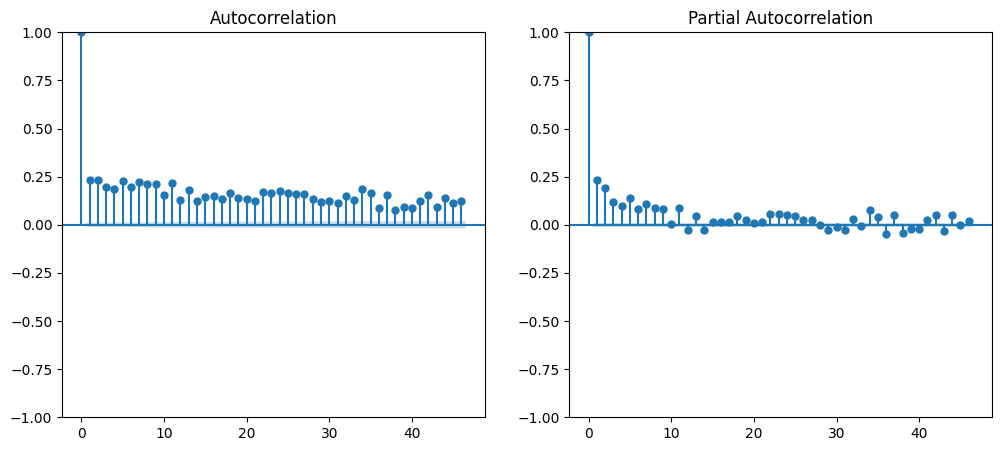

In [23]:
# Check for Stationarity
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationary' if result[1] < 0.05 else 'Non-Stationary')

adf_test(df['Value'])  # Replace with actual column name

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['Value'], ax=ax[0])
plot_pacf(df['Value'], ax=ax[1])
plt.show()

### 3.2 Time Series Chart

The following chart displays historical rent values across different regions. As an illustration, a time series chart showing California rent values is provided below.

In [34]:
import plotly.express as px
import pandas as pd

# Assuming your DataFrame 'df' has columns: 'Date', 'Value', 'RegionName', 'StateName'

# Group by StateName and get unique Region Names within each state
region_options_by_state = df.groupby('StateName')['StateName'].unique()

# Create a list to store the dropdown buttons
buttons = []

# Iterate through states (alphabetically)
for state in sorted(region_options_by_state.index):
    # Iterate through regions within each state
    for region in sorted(region_options_by_state[state]):
        label = f'{state} - {region}'
        filtered_df = df[df['StateName'] == region]
        buttons.append(
            {
                'label': label,
                'method': 'update',
                'args': [
                    {'x': [filtered_df['Date']], 'y': [filtered_df['Value']]},  # Ensure x-axis updates too
                    {'title': f'Time Series for {label}'}  # Correct way to update title
                ]
            }
        )

# Create the initial figure (using the first option)
first_state = sorted(region_options_by_state.index)[0]
first_region = sorted(region_options_by_state[first_state])[0]
initial_label = f'{first_state} - {first_region}'
initial_df = df[df['StateName'] == first_region]

fig = px.line(initial_df, x='Date', y='Value',
              title=f'Time Series for {initial_label}',
              labels={'Value': 'Value', 'Date': 'Date'})

# Define the update menus (dropdown)
updatemenus = [
    {
        'buttons': buttons,
        'direction': 'down',
        'pad': {'r': 10, 't': 10},
        'showactive': True,
        'x': 0.1,
        'xanchor': 'left',
        'y': 1.15,
        'yanchor': 'top'
    }
]

# Add the dropdown to the layout
fig.update_layout(updatemenus=updatemenus)

fig.show()


### 3.3 Top and Bottom 5 Rent Values by City and State 
First chart list the top 5 cities that are driving the rent prices. Second chart shows the list of 5 cities with the lowest rent. 

In [10]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Load the dataset
df = pd.read_csv('melted_dataframe.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Create a dropdown widget for state selection
state_options = df['StateName'].unique().tolist()
state_dropdown = widgets.Dropdown(
    options=state_options,
    description='Select State:',
    disabled=False,
)

# Function to update plots based on selected state
def update_plots(selected_state):
    # Filter data for the selected state
    last_10_years = df[df['Date'].dt.year >= df['Date'].dt.year.max() - 10]
    state_data = last_10_years[last_10_years['StateName'] == selected_state]

    # Top 5 Regions
    top_regions = state_data.groupby('RegionName')['Value'].mean().nlargest(5).reset_index()
    fig_top = px.bar(top_regions, x='RegionName', y='Value', 
                     title=f"Top 5 Regions Driving Rent Prices in {selected_state}",
                     labels={'Value': 'Average Rent Value', 'RegionName': 'Region'})
    fig_top.show()

    # Bottom 5 Regions
    bottom_regions = state_data.groupby('RegionName')['Value'].mean().nsmallest(5).reset_index()
    fig_bottom = px.bar(bottom_regions, x='RegionName', y='Value', 
                        title=f"Lowest 5 Regions Driving Rent Prices in {selected_state}",
                        labels={'Value': 'Average Rent Value', 'RegionName': 'Region'})
    fig_bottom.show()

# Connect the dropdown to the update function
def on_state_change(change):
    update_plots(change.new)

state_dropdown.observe(on_state_change, names='value')

# Display the dropdown
display(state_dropdown)


Dropdown(description='Select State:', options=('NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ', 'MI…

#### 3.4 Regional Rent Price Stability:

This chart gives you a snapshot of how stable rent prices are across different regions in California. The higher the bar, the more stable the rent prices have been. It looks like they're using the inverse of the Coefficient of Variation (CV) to measure this – so a lower CV (meaning less fluctuation) results in a higher stability score.

Right off the bat, you can see that Sonora, CA and Ukiah, CA show the highest rent price stability among the regions listed. On the other end, places like Merced, CA and Santa Maria, CA appear to have experienced more fluctuation in rent prices, resulting in lower stability scores.

In [24]:
import pandas as pd
import numpy as np
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Assuming 'df' is your DataFrame and it's already loaded
# If not, load it first:
# df = pd.read_csv('melted_dataframe.csv')
# df['Date'] = pd.to_datetime(df['Date'])

def calculate_rent_stability(df, selected_state):
    """
    Calculates and displays the stability of rent prices for each region within a selected state.
    Stability is measured by the inverse of the coefficient of variation (standard deviation / mean).
    Higher values indicate more stable rent prices.
    """

    state_data = df[df['StateName'] == selected_state].copy()  # Create a copy to avoid modifying the original DataFrame

    # Ensure 'Value' column is numeric
    state_data['Value'] = pd.to_numeric(state_data['Value'], errors='coerce')
    state_data = state_data.dropna(subset=['Value'])  # Remove rows with NaN values in 'Value'

    # Calculate mean and standard deviation for each region
    region_stats = state_data.groupby('RegionName')['Value'].agg(['mean', 'std'])
    region_stats = region_stats.dropna()  # Drop any regions where std is NaN (meaning only one data point)

    # Calculate coefficient of variation
    region_stats['cv'] = region_stats['std'] / region_stats['mean']

    # Calculate stability (inverse of coefficient of variation)
    region_stats['stability'] = 1 / region_stats['cv']

    # Sort by stability
    region_stats = region_stats.sort_values('stability', ascending=False)

    # Display results (Top 10 most stable and Top 10 least stable)
    print(f"Top 10 Most Stable Regions in {selected_state}:")
    print(region_stats.head(10))

    print(f"\nTop 10 Least Stable Regions in {selected_state}:")
    print(region_stats.tail(10))

    # Plotting the stability values
    fig = px.bar(region_stats, x=region_stats.index, y='stability',
                 title=f'Rent Price Stability by Region in {selected_state}',
                 labels={'stability': 'Stability (Inverse of CV)', 'RegionName': 'Region'})
    fig.show()

# Interactive part with dropdown
state_options = df['StateName'].unique().tolist()
state_dropdown = widgets.Dropdown(
    options=state_options,
    description='Select State:',
    disabled=False,
)

def on_state_change(change):
    calculate_rent_stability(df.copy(), change.new)  # Pass a copy to avoid modifying original

state_dropdown.observe(on_state_change, names='value')
display(state_dropdown)


Dropdown(description='Select State:', options=('NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ', 'MI…

### 3.5 Seasonal patterns in rent prices by region and by month (2nd chart).

1st Chart: The seasonal rent price patterns in California, as illustrated by the line chart, reveal a dynamic ebb and flow throughout the year. Starting in January, the average rent value gradually climbs until it reaches a notable peak around April. Interestingly, this is followed by a sharp dip to its lowest point in May. From this low, the average rent begins a steady ascent, culminating in the highest rent values observed around October. As the year draws to a close, the average rent experiences a slight decline from October to December. This cyclical movement suggests the presence of seasonal factors that influence rental costs across the state.

2nd Chart: The seasonal rent price patterns in California, as illustrated by the line chart, reveal a dynamic ebb and flow throughout the year. Starting in January, the average rent value gradually climbs until it reaches a notable peak around April. Interestingly, this is followed by a sharp dip to its lowest point in May. From this low, the average rent begins a steady ascent, culminating in the highest rent values observed around October. As the year draws to a close, the average rent experiences a slight decline from October to December. This cyclical movement suggests the presence of seasonal factors that influence rental costs across the state. The highest average value tends to be on April ($1,993) followed by lowest average value on May ($1,979)



In [12]:
import pandas as pd
import numpy as np
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Assuming 'df' is your DataFrame and it's already loaded
# If not, load it first:
# df = pd.read_csv('melted_dataframe.csv')
# df['Date'] = pd.to_datetime(df['Date'])

def analyze_seasonal_patterns(df, selected_state):
    """
    Analyzes and visualizes seasonal patterns in rent prices for a selected state.
    """

    state_data = df[df['StateName'] == selected_state].copy()

    # Ensure 'Value' column is numeric
    state_data['Value'] = pd.to_numeric(state_data['Value'], errors='coerce')
    state_data = state_data.dropna(subset=['Value'])

    # Group by month and calculate average rent
    state_data['Month'] = state_data['Date'].dt.month
    monthly_avg = state_data.groupby('Month')['Value'].mean().reset_index()

    # Create a line plot of monthly average rent
    fig = px.line(monthly_avg, x='Month', y='Value',
                  title=f'Seasonal Rent Price Patterns in {selected_state}',
                  labels={'Value': 'Average Rent Value', 'Month': 'Month'})

    fig.update_xaxes(tickvals=list(range(1, 13)),
                     ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    fig.show()

    # Further analysis: Box plots by month to show distribution
    fig_box = px.box(state_data, x='Month', y='Value',
                     title=f'Rent Price Distribution by Month in {selected_state}',
                     labels={'Value': 'Rent Value', 'Month': 'Month'})
    fig_box.update_xaxes(tickvals=list(range(1, 13)),
                     ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    fig_box.show()



# Interactive part with dropdown
state_options = df['StateName'].unique().tolist()
state_dropdown = widgets.Dropdown(
    options=state_options,
    description='Select State:',
    disabled=False,
)

def on_state_change(change):
    analyze_seasonal_patterns(df.copy(), change.new)  # Pass a copy to avoid modifying original

state_dropdown.observe(on_state_change, names='value')
display(state_dropdown)


Dropdown(description='Select State:', options=('NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ', 'MI…

#### 3.6 Heatmap of the dataframe

It shows that the variables are not correlated for all states.

In [26]:
print(df.dtypes)

RegionID               int64
SizeRank               int64
RegionName            object
RegionType            object
StateName             object
Date          datetime64[ns]
Value                float64
dtype: object


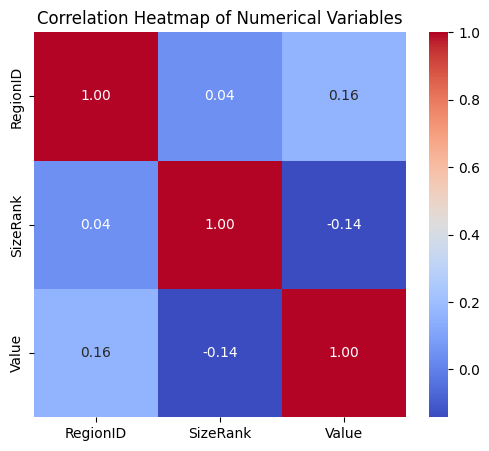

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is 'df'

correlation_matrix = df[['RegionID', 'SizeRank', 'Value']].corr() # Explicitly select numerical columns

plt.figure(figsize=(6, 5)) # Adjust size as needed for fewer variables
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

#### 3.7 Data Distribution of Rent Value per State 

Overall, data tends to skew to the right but not heavily. Example below shows the distribution chart for CA rent values. 

In [29]:
import plotly.express as px
import pandas as pd

# Assuming your DataFrame 'df' has columns: 'StateName', 'Value'

# Get unique states
unique_states = sorted(df['StateName'].unique())

# Create buttons for each state
distribution_buttons = []
for state in unique_states:
    filtered_df = df[df['StateName'] == state]
    distribution_buttons.append(
        {
            'label': f'{state}',
            'method': 'update',
            'args': [
                {'x': [filtered_df['Value']], 'y': [None]},  # Histogram needs only 'x'
                {'title': f'Data Distribution for {state}'}
            ]
        }
    )

# Create the initial figure (default: first state)
first_state = unique_states[0]
initial_df = df[df['StateName'] == first_state]

fig = px.histogram(initial_df, x='Value', nbins=30,  # Adjust bins as needed
                   title=f'Data Distribution for {first_state}',
                   labels={'Value': 'Value Frequency'})

# Define the dropdown menu
updatemenus = [
    {
        'buttons': distribution_buttons,
        'direction': 'down',
        'pad': {'r': 10, 't': 10},
        'showactive': True,
        'x': 0.1,
        'xanchor': 'left',
        'y': 1.15,
        'yanchor': 'top'
    }
]

# Add the dropdown to the layout
fig.update_layout(updatemenus=updatemenus)

fig.show()


# 4. Time Series Models

Below presents the breakdown of time series analysis per state. For instance for California, the three models produce the following matrices: 

Mean Absolute Error (MAE) for CA: <br>
<br>ARIMA: 613.5557<br>
<br>SARIMA: 802.4721<br>
<br>Prophet: 698.2459<br>

Above scores indicate that ARIMA model performed the best. 

In [ ]:
# Dictionary to store MAE scores
mae_scores = []

# Forecasting and MAE Calculation by State
def forecast_and_evaluate(state):
    state_df = df[df['StateName'] == state].copy()

    # Ensure at least 24 data points for training (avoid errors)
    if len(state_df) < 24:
        print(f"Skipping {state} due to insufficient data (<24 records).")
        return

    # ARIMA Model
    model_arima = ARIMA(state_df['Value'], order=(1,1,1))
    model_arima_fit = model_arima.fit()
    forecast_arima = model_arima_fit.forecast(steps=12)
    
    # Ensure correct length alignment
    actual_values_arima = state_df['Value'].iloc[-12:].values
    mae_arima = mean_absolute_error(actual_values_arima, forecast_arima[:len(actual_values_arima)])

    # SARIMA Model
    model_sarima = SARIMAX(state_df['Value'], order=(1,1,1), seasonal_order=(1,1,1,12))
    model_sarima_fit = model_sarima.fit()
    forecast_sarima = model_sarima_fit.forecast(steps=12)
    
    # Ensure correct length alignment
    actual_values_sarima = state_df['Value'].iloc[-12:].values
    mae_sarima = mean_absolute_error(actual_values_sarima, forecast_sarima[:len(actual_values_sarima)])

    # Prophet Model
    df_prophet = state_df[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})

    model_prophet = Prophet()
    model_prophet.fit(df_prophet)

    # Generate future dates correctly
    future = model_prophet.make_future_dataframe(periods=12, freq='M')
    forecast_prophet = model_prophet.predict(future)
    forecast_prophet_values = forecast_prophet[['ds', 'yhat']].tail(12)

    # Align actual and forecasted values for MAE calculation
    actual_values_prophet = state_df[state_df['Date'].isin(forecast_prophet_values['ds'])]['Value']
    
    # Ensure correct length alignment
    if len(actual_values_prophet) == len(forecast_prophet_values):
        mae_prophet = mean_absolute_error(actual_values_prophet, forecast_prophet_values['yhat'])
    else:
        actual_values_prophet = state_df['Value'].iloc[-12:]  # Fallback to last 12 known values
        mae_prophet = mean_absolute_error(actual_values_prophet, forecast_prophet_values['yhat'])

    # Store MAE scores
    mae_scores.append({'State': state, 'MAE_ARIMA': mae_arima, 'MAE_SARIMA': mae_sarima, 'MAE_Prophet': mae_prophet})

    # Plot using Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=state_df['Date'], y=state_df['Value'], mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=pd.date_range(start=state_df['Date'].iloc[-1], periods=12, freq='M'), 
                             y=forecast_arima, mode='lines', name='ARIMA Forecast'))
    fig.add_trace(go.Scatter(x=pd.date_range(start=state_df['Date'].iloc[-1], periods=12, freq='M'), 
                             y=forecast_sarima, mode='lines', name='SARIMA Forecast'))
    fig.add_trace(go.Scatter(x=forecast_prophet_values['ds'], y=forecast_prophet_values['yhat'], 
                             mode='lines', name='Prophet Forecast'))
    fig.update_layout(title=f'12-Month Forecast for {state}', xaxis_title='Date', yaxis_title='Value')
    fig.show()

    # Display MAE Scores
    print(f"Mean Absolute Error (MAE) for {state}:")
    print(f"ARIMA: {mae_arima:.4f}")
    print(f"SARIMA: {mae_sarima:.4f}")
    print(f"Prophet: {mae_prophet:.4f}")

# Dropdown Menu for State Selection
states = df['StateName'].unique()
dropdown = widgets.Dropdown(options=states, description='Select State:', continuous_update=False)
output = widgets.Output()

def on_state_change(change):
    if change['new']:
        output.clear_output(wait=True)
        with output:
            forecast_and_evaluate(change['new'])

dropdown.observe(on_state_change, names='value')
display(dropdown, output)

# Plot MAE scores for all states
def plot_mae_scores():
    mae_df = pd.DataFrame(mae_scores)
    if not mae_df.empty:
        fig = px.bar(mae_df.melt(id_vars=['State'], var_name='Model', value_name='MAE'),
                     x='State', y='MAE', color='Model',
                     title='MAE Scores for ARIMA, SARIMA, and Prophet by State')
        fig.show()

# Button to display MAE chart
mae_button = widgets.Button(description="Show MAE Chart")
mae_output = widgets.Output()

def on_mae_button_click(b):
    mae_output.clear_output(wait=True)
    with mae_output:
        plot_mae_scores()

mae_button.on_click(on_mae_button_click)
display(mae_button, mae_output)


Dropdown(description='Select State:', options=('NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ', 'MI…

Output()

Button(description='Show MAE Chart', style=ButtonStyle())

Output()

#### Time Series Analysis - All States 

In [35]:


# National-Level Forecasting
df_national = df.groupby('Date').agg({'Value': 'sum'}).reset_index()

# ARIMA for National-Level Forecast
model_arima_national = ARIMA(df_national['Value'], order=(1,1,1))
model_arima_national_fit = model_arima_national.fit()
national_forecast_arima = model_arima_national_fit.forecast(steps=12)
mae_arima_national = mean_absolute_error(df_national['Value'][-12:], national_forecast_arima)

# SARIMA for National-Level Forecast
model_sarima_national = SARIMAX(df_national['Value'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_sarima_national_fit = model_sarima_national.fit()
national_forecast_sarima = model_sarima_national_fit.forecast(steps=12)
mae_sarima_national = mean_absolute_error(df_national['Value'][-12:], national_forecast_sarima)

# Prophet for National-Level Forecast
df_prophet_national = df_national.rename(columns={'Date': 'ds', 'Value': 'y'})
model_prophet_national = Prophet()
model_prophet_national.fit(df_prophet_national)
national_future = model_prophet_national.make_future_dataframe(periods=12, freq='M')
national_forecast_prophet = model_prophet_national.predict(national_future)
national_forecast_prophet_values = national_forecast_prophet[['ds', 'yhat']].tail(12)
mae_prophet_national = mean_absolute_error(df_national['Value'][-12:], national_forecast_prophet_values['yhat'])

# Plot National-Level Forecast using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_national['Date'], y=df_national['Value'], mode='lines+markers', name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=pd.date_range(start=df_national['Date'].iloc[-1], periods=12, freq='M'), y=national_forecast_arima, mode='lines+markers', name='ARIMA Forecast', line=dict(color='red', dash='dash')))
fig.add_trace(go.Scatter(x=pd.date_range(start=df_national['Date'].iloc[-1], periods=12, freq='M'), y=national_forecast_sarima, mode='lines+markers', name='SARIMA Forecast', line=dict(color='green', dash='dot')))
fig.add_trace(go.Scatter(x=national_forecast_prophet_values['ds'], y=national_forecast_prophet_values['yhat'], mode='lines+markers', name='Prophet Forecast', line=dict(color='purple', dash='longdash')))
fig.update_layout(title='12-Month National-Level Forecast', xaxis_title='Date', yaxis_title='Value', template='plotly_white')
fig.show()

# Display MAE Scores
print("Mean Absolute Error (MAE) for National-Level Forecast:")
print(f"ARIMA: {mae_arima_national:.4f}")
print(f"SARIMA: {mae_sarima_national:.4f}")
print(f"Prophet: {mae_prophet_national:.4f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83170D+00    |proj g|=  1.18562D+00

At iterate    5    f=  9.27242D+00    |proj g|=  2.29146D-02

At iterate   10    f=  9.27178D+00    |proj g|=  7.88333D-02

At iterate   15    f=  9.26921D+00    |proj g|=  4.63832D-03

At iterate   20    f=  9.26054D+00    |proj g|=  1.22898D-02

At iterate   25    f=  9.24700D+00    |proj g|=  1.04718D-03

At iterate   30    f=  9.24432D+00    |proj g|=  2.13076D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
16:46:57 - cmdstanpy - INFO - Chain [1] start processing



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     54      1     0     0   2.436D-03   9.244D+00
  F =   9.2441956246676487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


16:46:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE) for National-Level Forecast:
ARIMA: 186850.0363
SARIMA: 278736.9069
Prophet: 144211.9065


# 5. Final Summary

This analysis provides a **comprehensive view of U.S. rental market trends**, helping stakeholders make **data-driven housing decisions**.  

### **Key Takeaways:**  

1. **Rent Prices Have a Strong Autoregressive Component**  
   - Historical rent prices significantly impact future trends, as indicated by **high autocorrelation** in the time series data.  
   - A **stationary transformation** was necessary for effective forecasting.  

2. **Top and Bottom Cities by Rent Prices Reveal Market Disparities**  
   - **High-rent cities** (e.g., San Francisco, New York) indicate strong housing demand and limited supply.  
   - **Low-rent cities** may offer more affordability but could reflect lower economic activity or housing oversupply.  

3. **Rent Price Stability Varies Across Cities**  
   - Cities like **Sonora, CA** and **Ukiah, CA** exhibit **stable rental markets**, ideal for investors seeking predictability.  
   - Cities such as **Merced, CA** and **Santa Maria, CA** show **high fluctuations**, which may signal volatile demand or seasonal influences.  

4. **Seasonal Trends Affect Rent Pricing**  
   - Rent peaks in **April ($1,993)** and dips in **May ($1,979)** before gradually rising until **October**.  
   - This suggests seasonal demand fluctuations, possibly linked to:  
     - **Lease renewals & school terms** (e.g., families moving in summer).  
     - **Economic cycles** affecting affordability.  

5. **Modeling Suggests ARIMA is the Best Forecaster**  
   - **ARIMA (MAE: 613.56)** outperforms **SARIMA (802.47)** and **Prophet (698.25)** for predicting future rent prices.  
   - This highlights that **simple models can be effective** for short-term forecasting in rental markets.  

### **Implications for Stakeholders:**  
- 📌 **Renters** can plan better by understanding seasonal variations and targeting **low-rent months** for leases.  
- 📈 **Real estate investors** can use stability analysis to identify **low-volatility markets** for long-term investments.  
- 🏛 **Policymakers & urban planners** can focus on regions with rising rents to implement **affordability measures**.  

### **Future Work & Recommendations:**  
- 🔍 Incorporate **macro-economic indicators** (e.g., inflation, interest rates, employment) to refine rent price predictions.  
- 🌍 Use **Geospatial Analysis** to explore neighborhood-level rent dynamics.  
- 📊 Expand the dataset beyond Zillow to include **additional rental sources** for broader market coverage.  

By leveraging time series modeling and exploratory data analysis, this study provides **actionable insights into the U.S. rental market**, supporting **better decision-making for renters, investors, and policymakers**.  
